# Dynamische Programmierung
## Dirkete Verfahren, volldiskretisierung

In [100]:
import numpy as np
import scipy as sp
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

from scipy.optimize import minimize, Bounds, LinearConstraint, BFGS
from scipy import sparse
import scipy.signal as sig

## 1. Model

In [101]:
global nx, nu, nxu, N, t, Ta, S, M, Q, R, b_


t_end = 4
N = 50
t = np.linspace(0,t_end,N)

# Anzahl an Zuständen und Eingängen
nx = 4
nu = 1
nxu = nx+nu

Ta = t_end/N

S = np.zeros((nx,nx))
S[2,2] = 5

M = np.eye(4)
Q = np.eye(4)
R = np.array([[0.1]])
b_ = [0,0,0,0]

In [102]:
# Parameter
global J,a,m,d,g

J = 0.0361  # kgm²
a = 0.42    # m
m = 0.3553  # kg
d = 0.005   # Nms
g = 9.81    # m/s²

In [103]:
# System dynamic

def System_dynamic(x,u):
    dx = np.zeros(nx)
    dx[0] = x[1]
    dx[1] = (m*g*np.sin(x[1])+m*a*np.cos(x[0])*u-d*x[1])/(J+m*a**2) 
    dx[2] = x[3]
    dx[3] = u

    return dx



In [104]:
# Ableitungen

def dfdx(x,u):    
    A =np.zeros((nx,nx))
    A[0,1] = (m*g*np.cos(x[0])-m*a*np.sin(x[0])*u)/(J+m*a**2)   
    A[1,1] = -d/(J+m*a**2)                                      
    A[2,3] = 1                                                  
    return A

def dfdu(x,u):    
    B = np.zeros((nx,nu))                                        
    B[1,0] = (m*a*np.cos(x[0]))/(J+m*a**2)                        
    B[3,0] = 1                                                    
    return B


## Minimization with Scipy minimize
### Setup Problem

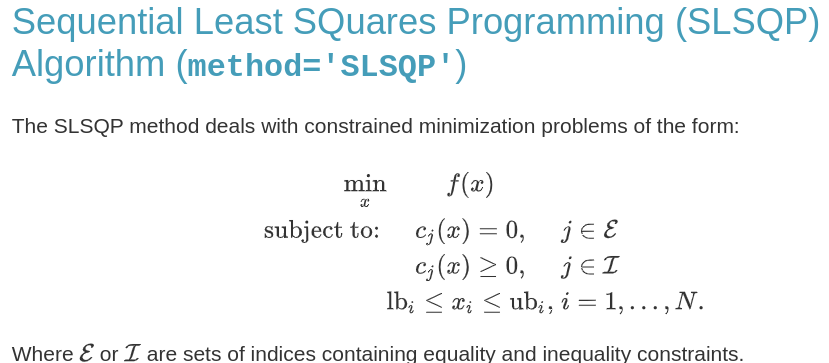

In [105]:
# Kostenfunktion

l  = lambda x,Q: 1+x.T@Q@x/2
dl = lambda x,Q: Q@x               


def cost(y):
    # y = [x0 u0, x1 u1, ....., xN uN]   mit x = [x0 x1 x2 x3 ..], und u = [u0,u1,u2,u3,...]     
    
    cost_ = y[-nxu:-nu]@S@y[-nxu:-nu]/2    # Endkostenterm 0.5*xSx
    
    for k in range(0,N-1):
        k0 = (k)*nxu      
        k1 = (k+1)*nxu            
        cost_ += (t[k+1]-t[k])/2*( l(y[k0:k0+nxu], block_diag(Q,R))+ l(y[k1:k1+nxu],block_diag(Q,R)) )    #  laufende Kosten  1 + 0.5*(xQx + uRu)
               
    return cost_

def costdx(y):
    # Ableitung der Kosten      
    
    dJdy = np.zeros((nxu*N))
    dJdy[-nxu:] = dl(y[-nxu:],block_diag(S,R*0))   
    for k in range(0,N-1):
        k0 = (k)*nxu      
        k1 = (k+1)*nxu    
        #print(k0,k1)  
        dJdy[k0:k1] = (t[k+1]-t[k])/2*( dl(y[k0:k0+nxu],block_diag(Q,R))+ dl(y[k1:k1+nxu],block_diag(Q,R)) )     
    
    return dJdy


#y_ = np.ones(N*nxu)*2

#cost(y_)
#a_ = df_eq_cons(y_)
#a_ = a_*100

#print(np.array([a_[:14,:14]],int))




In [106]:
global x0, xN, xNN, X0
x0 = np.array([np.pi,0,0,0])
#x0 = np.array([2,2,2,2])
xN = np.array([0,0,0.0,0])
xNN = np.array([0,0,0,0,0])


xmin = np.array([-np.inf, -np.inf, -0.7, -np.inf])
xmax = np.array([np.inf, np.inf, 0.7, np.inf])
umin = np.array([-10])
umax = np.array([10])

# y = [x0 u0, x1 u1, ......., x_N u_N]

Ad,Bd,Cd,Dd,Ta = sig.cont2discrete((dfdx(x0,0.1),dfdu(x0,0.1),np.zeros((nx,nu)),0),Ta, method='zoh')


# - quadratic objective

P = sparse.block_diag([sparse.kron(sparse.eye(N-1),  sparse.block_diag([Q,R])), sparse.block_diag([S,R*0]) ], format='csc')

#P = sparse.block_diag([sparse.kron(sparse.eye(N-1), sparse.block_diag([Q,R])), S, sparse.block_diag([S,R*0])], format='csc')
# - linear objective
#q = np.hstack([np.kron(np.ones(N), -Q.dot(xr)), -S.dot(xr),np.zeros(N*nu)])

#Aeq =  sparse.kron(sparse.eye(N),np.hstack([-np.eye(nx),np.zeros((nx,nu))]) ) + sparse.kron(sparse.eye(N, k=-1), np.hstack([Ad,Bd]))
Aeq =  sparse.kron(sparse.eye(N),np.hstack([-np.eye(nx),np.zeros((nx,nu))]) ) + sparse.kron(sparse.eye(N, k=-1), np.hstack([Ad,Bd]))
#Ax   = sparse.kron(sparse.eye(N+1),-sparse.eye(nx)) + sparse.kron(sparse.eye(N, k=-1), np.hstack([Ad,Bd]))

leq = np.hstack([-x0, np.zeros((N-2)*(nx)), -xN])
ueq = leq.copy()


# Inequality constraints, like input and state constraints
Aineq = sparse.eye(N*(nx+nu))
#print(nx+nu)
lineq =  np.kron(np.ones(N), np.hstack([xmin, umin]))
uineq =  np.kron(np.ones(N), np.hstack([xmax, umax]))


# - OSQP constraints
Ab = sparse.vstack([Aeq, Aineq], format='csc')
lb = np.hstack([leq, lineq])
ub = np.hstack([ueq, uineq])

X0 = np.hstack([x0,0, np.zeros((N-2)*(nx+nu)), xN@M,0])
#eq_const = [-x0,np.zeros(nu*nx*N)  ]

#print(P.toarray())

print(np.shape(Aeq))
print(np.shape(leq))
#print(np.shape(ueq))

#print(Aeq.toarray())

#print(Aeq.toarray())
#print(Ax.toarray())
#print(np.array([Aeq.toarray()], int))



(200, 250)
(200,)


In [107]:

# Bounds  --> x, u
bounds = Bounds(lineq, uineq)

# Equality Constraints
linear_constraint = LinearConstraint(Aeq,leq, ueq)

res = minimize(cost, X0, method='SLSQP', jac=costdx,
               constraints=linear_constraint, options={'ftol': 1e-9 , 'disp': True},
               bounds=bounds)



Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.590726457971789
            Iterations: 39
            Function evaluations: 50
            Gradient evaluations: 39


In [108]:
def f_eq_cons(y):
    dx = np.zeros(nx*N)
    dx[:nx] =  -y[:nx]                # Startwert
    dx[-nx:] = -M@y[-nxu:-nu] + b_   # Endwert
    
    for i in range(1,N-1):               
        j, j1 = i*nxu, (i+1)*nxu         
        dx[i*nx:i*nx+nx] =  y[j1:j1+nx] -y[j:j+nx] - (t[i+1]-t[i])/2*(System_dynamic(y[j:j+nx],y[j+nx:j+nxu]) + System_dynamic(y[j1:j1+nx],y[j1+nx:j1+nxu]))
               
    return dx





def df_eq_cons(y):
    dx = np.zeros((N*nx,N*nxu))
    
    #dx[:nx,:nxu] =  np.hstack([ np.eye(nx), np.zeros((nx,nu)) ])    # Startdynamik
    #dx[-nx:,-nxu:-nu] = M                                            # Enddynamik
    
    for i in range(1,N-1):
        k, k1 =   i*nxu, (i+1)*nxu

        x, x1 = y[k:k+nx] , y[k1:k1+nx]
        u, u1 = y[k+nx:k+nxu], y[k1+nx:k1+nxu] 

        dt = (t[i+1]-t[i])/2
        #  dx[i] = [A | B | -I | 0]
        dx[i*nx:(i+1)*nx,k-nxu:k+2*nxu-nxu] = np.hstack([ dt*dfdx(x,u),dt*dfdu(x,u) ,  -np.eye(nx) +-dt*dfdx(x1,u1),-dt*dfdu(x1,u1) ]) 
        
        #  dx[i] = [-A | -B | -A | -B]
        #dx[i*nx:(i+1)*nx,k:k+2*nxu] = np.hstack([ -dt*dfdx(y[k:k+nx],y[k+nx:k+nxu]),-dt*dfdu(y[k:k+nx],y[k+nx:k+nxu]) ,  -dt*dfdx(y[k1:k1+nx],y[k1+nx:k1+nxu]),-dt*dfdu(y[k1:k1+nx],y[k1+nx:k1+nxu])   ])    
        
        #  dx[i] = [-I-A | -B | I-A | -B]        
        #dx[i*nx:(i+1)*nx,k:k+2*nxu] = np.hstack([ - np.eye(nx) -dt*dfdx(x,u),-dt*dfdu(x,u) ,  np.eye(nx) -dt*dfdx(x1,u1),-dt*dfdu(x1,u1) ]) 

        #  dx[i] = [ -A | B | I | 0]        
        #dx[i*nx:(i+1)*nx,(k-nxu):(k-nxu)+2*nxu] = np.hstack([ -dt*dfdx(x,u), -dt*dfdu(x,u) ,  np.eye(nx), np.zeros((nx,nu))]) 
    
    return dx


def df_eq_cons2(y):
    dx = np.zeros(N*nxu)
    
    dx[:nxu] =  np.hstack([ np.eye(nx)@y[:nx], np.zeros(nu) ])          # Startdynamik
    dx[-nx:] = M@y[-nxu:-nu]                                            # Enddynamik
    
    for i in range(1,N-1):
        k, k1 =   i*nxu, (i+1)*nxu
        x, x1 = y[k:k+nx] , y[k1:k1+nx]
        u, u1 = y[k+nx:k+nxu], y[k1+nx:k1+nxu] 

        dt = (t[i+1]-t[i])/2
        #  dx[i] = [A | B | -I | 0]
        #dx[i*nx:(i+1)*nx,k-nxu:k+2*nxu-nxu] = np.hstack([ dt*dfdx(x,u),dt*dfdu(x,u) ,  -np.eye(nx) +-dt*dfdx(x1,u1),-dt*dfdu(x1,u1) ]) 
        
        #  dx[i] = [-A | -B | -A | -B]
        #dx[i*nx:(i+1)*nx,k:k+2*nxu] = np.hstack([ -dt*dfdx(y[k:k+nx],y[k+nx:k+nxu]),-dt*dfdu(y[k:k+nx],y[k+nx:k+nxu]) ,  -dt*dfdx(y[k1:k1+nx],y[k1+nx:k1+nxu]),-dt*dfdu(y[k1:k1+nx],y[k1+nx:k1+nxu])   ])    
        
        #  dx[i] = [-I-A | -B | I-A | -B]        
        #dx[i*nx:(i+1)*nx,k:k+2*nxu] = np.hstack([ -np.eye(nx) -dt*dfdx(x,u),-dt*dfdu(x,u) ,  np.eye(nx) -dt*dfdx(x1,u1),-dt*dfdu(x1,u1) ]) 

        #  dx[i] = [ -A | B | I | 0]        
        dx[i*nx:(i+1)*nx] =  -dt*dfdx(x,u)@x -dt*dfdu(x,u)@u +  np.eye(nx)@x1

    return dx
y_=np.ones(N*nxu)
x_ = df_eq_cons2(y_)
#print(np.array([10*x_],int))
#dfdu([1,1,1,1],[1])@[1] + M@[1,1,1,1]

In [129]:
from scipy.optimize import NonlinearConstraint
# Bounds  --> x, u
bounds = Bounds(lineq, uineq)

# Constraints
eq_cons = {'type': 'eq',
           'fun' : f_eq_cons,
           'jac' : df_eq_cons
           }

nonlinear_constraint = NonlinearConstraint(f_eq_cons, np.zeros(N*nx), np.zeros(N*nx))

#method = 'SLSQP'  
# trust-constr
res = minimize(cost, X0, method='SLSQP, jac=costdx,
               constraints=nonlinear_constraint, #options={'ftol': 1e-9, 'disp': True},
               bounds=bounds)



SyntaxError: unterminated string literal (detected at line 15) (2782978176.py, line 15)

In [121]:
# Simulate the dynamiks
from scipy.integrate import solve_ivp
def runge_kutta_k4(f,x,u,h=1):
        
    #RK4 integration with zero-order hold on u    
    f1 = f(x, u)
    f2 = f(x + 1/2*h*f1, u)
    f3 = f(x + 1/2*h*f2, u)
    f4 = f(x + h*f3, u)

    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)


def close_loop(res):
    xhist = np.zeros((nx,N))    
    uhist = np.zeros((nu,N))  

    uhist[:,:]=  res.x[4::5]
    xhist[:,0] = x0

    for k in range(0,N-1):                                               
               
        xhist[:,k+1] =  runge_kutta_k4(System_dynamic, xhist[:,k], uhist[:,k],h=Ta)  
       
              
    return xhist,uhist


In [122]:
xhist,uhist = close_loop(res)

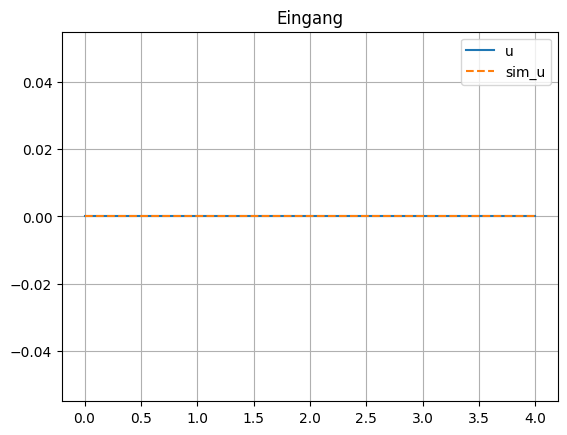

In [123]:
plt.plot(t,res.x[4::5], label = 'u')
plt.plot(t,uhist[0,:], label='sim_u', linestyle='--')
plt.title('Eingang')
plt.grid()
plt.legend()

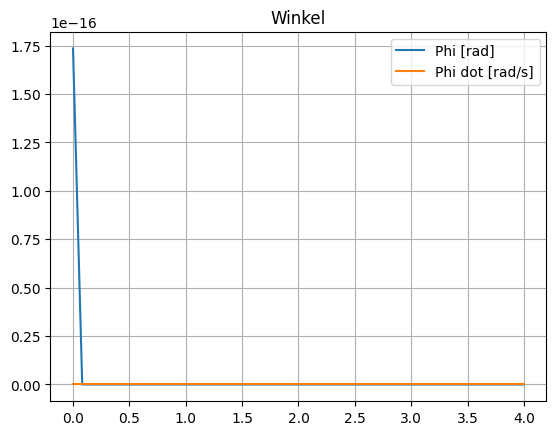

In [124]:
plt.plot(t,res.x[0::5], label = 'Phi [rad]')
plt.plot(t,res.x[1::5], label = 'Phi dot [rad/s]')
#plt.plot(t,xhist[0,:],   label='sim_Phi', linestyle='--')
#plt.plot(t,xhist[1,:],   label='sim_Phi_dot', linestyle='--')
plt.title('Winkel')
plt.grid()
plt.legend()

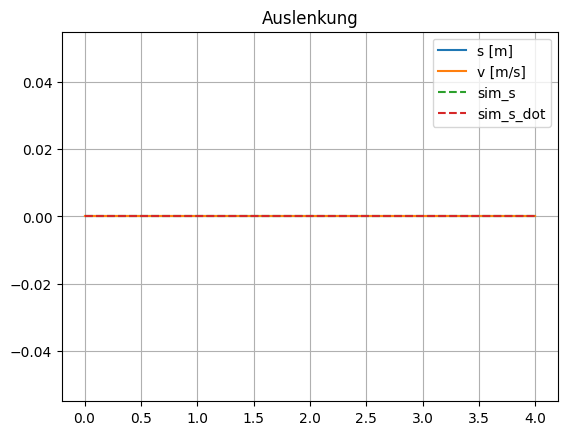

In [125]:
plt.plot(t,res.x[2::5], label = 's [m]')
plt.plot(t,res.x[3::5], label = 'v [m/s]')
plt.plot(t,xhist[2,:],   label='sim_s', linestyle='--')
plt.plot(t,xhist[3,:],   label='sim_s_dot', linestyle='--')
plt.title('Auslenkung')
plt.grid()
plt.legend()